In [1]:
import argparse
from typing import Any, List, Callable, Dict, Tuple

from GridWorld_environments import Grid_World
from RL_agents import ValueIterationAgent, QLearningAgent
from IRL_agents import IRL_from_sampled_trajectories
from plotting import plot_reward_3d

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from copy import deepcopy

### Definitions

#### Show Policy

In [2]:
def get_display_policy(policy: Dict[Tuple[int], Tuple[int]], actions_to_str_map: Dict[Tuple[int], str], size: Tuple[int], terminal_states: Tuple[int] ):

    policy_str = {state: actions_to_str_map[action] for state, action in policy.items()}
    policy_arr = np.zeros(size, str)

    for state in policy_str:
        policy_arr[state] = policy_str[state]

    for state in terminal_states:
        policy_arr[state] = "x"

    return policy_arr

#### Show Value function

In [3]:
def get_display_value_func(val_func: Dict[Tuple[int], Tuple[int]], size: Tuple[int], terminal_states: Tuple[int] ):

    val_func_disp = np.zeros(size)
    #policy_str = {state: actions_to_str_map[action] for state, action in policy.items()}
    #policy_arr = np.zeros(size, str)

    for state in val_func:
        val_func_disp[state] = val_func[state]

    for state in terminal_states:
        val_func_disp[state] = 0

    return val_func_disp

#### Perform Value evaluation function

In [4]:
def perform_value_evaluation(gw_env: Grid_World, policy: Dict[Any, Any], verbose=False):
    
    vi_agent = ValueIterationAgent(states=gw_env.get_state_space(),
                                   terminal_states=gw_env.get_terminal_states(),
                                   reward_function=gw_env.get_reward_func(),
                                   actions=gw_env.get_action_space(),
                                   gamma=GAMMA)
    
    while not vi_agent.value_converged:
        
        for state in gw_env.get_state_space():
            
            if state in gw_env.get_terminal_states():
                continue
                
            policy_act = policy[state]
            next_state = gw_env.get_new_state_on_action(old_state=state, action=policy_act)
            next_state_value = vi_agent.get_state_value(state=next_state)
            
            vi_agent.set_state_value(state=state, new_value=(gw_env.get_state_reward(state=next_state) + GAMMA * next_state_value))
        
    if verbose:
        gw_env.display_value_function(value_func=vi_agent.get_value_function())

    return vi_agent.get_value_function()
            

#### Perform Action-Value evaluation function (Q-Learning evaluation)

In [5]:
def perform_q_function_evaluation(gw_env: Grid_World, policy: Dict[Any, Any], rounding: int = 3):

    value_func = perform_value_evaluation(gw_env, policy)
    rewards = gw_env.get_reward_func()

    q_function = {}
    for state in gw_env.get_state_space():

        action_values = {}
        for action in gw_env.get_action_space():

            next_state = gw_env.get_new_state_on_action(old_state=state, action=action)
            action_values[action] = np.round(rewards[next_state] + GAMMA * value_func[next_state], rounding)
            
        q_function[state] = action_values

    return q_function
    

#### IRL Reward estimation function

In [6]:
def irl_reward_estimation(env: Grid_World, optimal_trajectories: List[List[Any]], train_func: Callable):

    # store reference reward function
    reward_func_ref = deepcopy(env.get_board())
    print('Reference reward function:\n', reward_func_ref)

    irl_agent = IRL_from_sampled_trajectories(d=(GW_SIZE[0] * 4, GW_SIZE[1] * 4),
                                              env_ranges=((0, GW_SIZE[0]), (0, GW_SIZE[1])),
                                              env_discrete_size=GW_SIZE,
                                              penalty_factor=2,
                                              gamma=GAMMA)

    # step 2: given optimal trajectories, compute the value estimate
    print("Computing value estimates for optimal trajectories...")
    optimal_value_estimate = irl_agent.compute_value_estimate(trajs=optimal_trajectories)

    candidate_policies = [env.construct_random_policy()]
    candidate_value_estimates = []
    reward_func_estimates = []

    # while True:
    for i in range(IRL_TRAINING_N):
        print(f"Iteration {i}...")

        # step 3: generate trajectories and compute the value estimate for a random policy
        print("Generating trajectories for the candidate policy...")
        candidate_trajectories = env.generate_trajectories(policy=candidate_policies[-1],
                                                           n_traj=NUMBER_OF_TRAJECTORIES,
                                                           max_traj_length=MAXIMUM_TRAJECTORY_LENGTH)
        print("Computing value estimates for condidate trajectories...")
        candidate_value_estimates.append(irl_agent.compute_value_estimate(trajs=candidate_trajectories))

        # step 4: obtain new alphas
        print("Solving linear programming...")
        irl_agent.solve_lp(optimal_value_estimate, candidate_value_estimates)

        # step 5: construct new reward function from the alphas
        reward_func = irl_agent.construct_reward_function(alphas=irl_agent.get_alphas())

        # step 6: find optimal policy under new reward function and add to 'candidate_policies' list
        env.set_reward_func(reward_func)
        candidate_policies.append(train_func(gw_env=env, verbose=True))  # train_value_iteration(gw_env=env))
        # store new reward function
        reward_func_estimates.append(env.get_board())
        
        print("Latest estimated reward function:\n", reward_func_estimates[-1])
        env.display_policy(policy=candidate_policies[-1])
        print("============================================================\n" * 2)

    return {'reference_reward_func': reward_func_ref, 'policy_pred': np.mean(np.array([list(pol.values()) for pol in candidate_policies]), axis=0), 'avg_predicted_reward_func': np.mean(np.array(reward_func_estimates), axis=0)}


def calc_value_distance(value_estimates_ref, value_estimates_pred):
    return np.linalg.norm(np.array(value_estimates_ref) - np.array(value_estimates_pred))

# Bayesian Inverse Reinforcement Learning

Max Serra and Niklas Kaspareit

## Table of contents

1. Motivation of IRL
2. Project Goal
3. Inverse Reinforcement Learning (IRL)
4. Bayesian Inverse Reinforcement Learning (BIRL)
5. Results
6. Outlook

# 1. Motivation of IRL

The problem of Inverse Reinforcement Learning has been defined in Learning agents for uncertain environments (Russel, 1998).

- **Determine**: reward function being optimized.
- **Given**: 1) Measurements of an agent's behavior over time, in a variety of circumstances 2) Measurements of the sensory inputs to that agent; 3) a model of the environment. ( Ng and Russel, 2000 )

<img src="presentation/rl-vs-irl.png" />

### The Bee hive
<img src="presentation/Bee_Hive_IRL.png" alt="bee hive" width="100%"/>
source: Niklas Kaspareit

motivation for this problem arises from e.g. animal and human learning.
example: 
Bee foraging -> 
bee searches for nectar. 
reward -> nectar in flower
possibly multiattribute: weight nectar ingestion against flight distance, time, risk from wind and predators.

Conclusion: hard to determine relative weights here

Often we want to learn a policy based on observation of an expert. However it is assumed that the reward function is known, which often is not the case. So we take the policy from the expert as given and infer the reward function.

## Table of contents

1. Motivation of IRL
2. **Project Goal**
3. Inverse Reinforcement Learning (IRL)
4. Bayesian Inverse Reinforcement Learning (BIRL)
5. Results
6. Outlook

# 2. Project Goal

- Compare different IRL algorithms. 
- IRL algorithm by Ng and Russel (2000) vs. Bayesian Inverse Reinforcement Learning by Ramachandran et al. (2007)
    - Using reward loss and policy loss

<br />
<br />


<div style="display: flex;   flex: 33.33%; padding: 1px;">
    <img src="presentation/BIRL_Paper_Reward_Loss.jpg" width=30%/>
    <img src="presentation/BIRL_Paper_Policy_Loss.jpg" width=30%/>
</div>

### Hyper parameters

In [7]:
GAMMA = 0.95
VALUE_ITERATION_TRAINING_N = 25
IRL_TRAINING_N = 10

NUMBER_OF_TRAJECTORIES = 400
MAXIMUM_TRAJECTORY_LENGTH = 10

GW_SIZE = (6, 6)
GW_SIZES = [(3, 3)]  # [(x, x) for x in np.arange(5,11, 5)]
GW_TRAPS = [(3,3)]
GW_GOALS = [(0, 0)]

In [8]:
#environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)

In [9]:
#vi_greedy_policy = train_value_iteration(gw_env=environment, verbose=True)

## Table of contents

1. Motivation of IRL
2. Project Goal
3. **Inverse Reinforcement Learning (IRL)**
4. Bayesian Inverse Reinforcement Learning (BIRL)
5. Results
6. Outlook

# 3. Inverse Reinforcement Learning (IRL)

## Algorithms for Inverse Reinforcement Learning (2000)
### Authors
Andrew Y. Ng
Stuart Russell

## Framework

Given 
- finite State space $\mathcal{S}$
- a set of $k$ actions $A = \{a_1, \cdots , a_k\}$
- transition probabilities $\{P_{sa}\}$
- discount factor $\gamma$ 
- policy $\pi$ in Markov Decision Process $(S, A, \{P_{sa}\}, \gamma, R)$

Constraint:
- only finite-state MDPs

- Required "tools"
    - value iteration
    - q learning

## Linear function approximation

<img src="presentation/IRL_trajectories_2.jpg" width="60%"/>

- For a general solution of $R$ we require all function to map $\mathbb{R}^n \rightarrow \mathbb{R}$
    - Hard to work with this, therefore we choose a linear approximation
    
$ \quad R(s) = \alpha_1 \phi_1(s) + \alpha_2 \phi_2(s) + \cdots + \alpha_d \phi_d(s) $

with the $\phi$s being fixed basis functions mapping from state $S$ into $\mathbb{R}$ and the $\alpha_i$s a are the parameters that can be fit and optimized for the reward function.

Using linearity of expectations value function $V_i^\pi$ for the policy $\pi$ is given by

$ \quad V^\pi = \alpha_1 V_1^\pi + \cdots + \alpha_d V_d^\pi$

### IRL from Sampled Trajectories

- Access to policy $\pi$ only through a set of trajectories.
- Assume that optimal policy can be found by choosing a reward function
- No explicit model of MDP required


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal;">
        <li style="font-size:1.5em">
            For each $i = 1, \cdots , d$ define $\hat{V}_i^\pi(s_0)$.</li>
        <li style="font-size:1.5em; margin: 1em 0em; list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Being the average empirical return on the samples trajectories with reward $R$</li>
                <li style="list-style-type:none;">
                    <ul>
                        <li style="font-size:0.85em; margin: 0.5em 0em;">$\hat{V}_i^\pi(s_0) = \phi_i(s_0) + \gamma \phi_i(s_1) + \gamma^2 \phi_i(s_2) + \cdots $ </li>
                    </ul>
                </li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">For any setting of $\alpha_i$s the natural estimate of $\hat{V}^\pi(s_0)$ is:</li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$\hat{V}^\pi(s_0) = \alpha_1 \hat{V}_1^\pi(s_0) + \cdots + \alpha_d \hat{V}_d^\pi(s_0) $</li>
            </ul>
        </li>
    </ul>

<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal;font-size:1.5em;">
        <li style="margin: 1em 0em">Given a reward function $R$ determine optimal policy $\pi^*$</li>
        <li style="margin: 1em 0em">sample $m$ (optimal) Monte Carlo trajectories under $\pi^*$</li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_initial.png" width=65% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:1em;">
        <li style="margin: 1em 0em">Compute the optimal value function $\hat{V}^{\pi^*}$ with $\pi^*$</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.75em; margin: 0.5em 0em;">With:</li>
                <li style="font-size:0.65em; margin: 0.5em 0em;">$\hat{V}_i^{\pi^*}(s_0) = \phi_i(s_0) + \gamma \phi_i(s_1) + \gamma^2 \phi_i(s_2) + \cdots $ </li>
            </ul>
        </li>
        <li style="margin: 1em 0em; font-size:0.8em;">$\hat{V}^\pi(s_0) = \alpha_1 \hat{V}_1^\pi(s_0) + \cdots + \alpha_d \hat{V}_d^\pi(s_0) $</li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_1.png" width=60% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <img src="presentation/IRL_Algo_Sampled_Trajectories_2.png" width=80% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:1em;">
        <li style="margin: 1em 0em">Follow the procedure analogously to the initialization and 1.</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Generate trajectories based on $\pi_k$ </li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Compute value estimates with:</li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$\hat{V}_i^\pi(s_0) = \phi_i(s_0) + \gamma \phi_i(s_1) + \gamma^2 \phi_i(s_2) + \cdots $ </li>
            </ul>
        </li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_4.png" width=65% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:0.9em;">
        <li style="margin: 1em 0em">Now the idea is to use some "inductive step" to fit the $\alpha_i$s and we want to achieve this:</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$V^{\pi^*} \geq V^{\pi_i}(s_0), \qquad i = 1, \cdots , k$</li>
            </ul>
        </li>
        <li style="margin: 1em 0em">By modification of this we get</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$\text{maximize} \sum_{i=1}^{k} p \left ( \hat{V}^{\pi^*}(s_0) - \hat{V}^{\pi_i}(s_0) \right ) $</li>
                <li style="font-size:0.85em; margin: 0.5em 0em; list-style-type:none;">$s.t. |\alpha_i| \leq 1, \quad i = 1, \cdots , d $</li>
            </ul>
        </li>
        <li style="margin: 1em 0em">$\hat{V}^{\pi^*}(s_0)$ and $\hat{V}^{\pi_i}(s_0)$ are linear functions.</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Hence the problem can be solved via linear programming. (e.g. using the Simplex method)</li>
            </ul>
        </li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_5.png" width=65% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:1.5em;">
        <li style="margin: 1em 0em">$\hat{V}^{\pi^*}(s_0)$ and $\hat{V}^{\pi_i}(s_0)$ are linear functions.</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Hence the problem can be solved via linear programming. (e.g. using the Simplex method)</li>
            </ul>
        </li>
        <li style="margin: 1em 0em">$p(x)$ is chosen as described in the paper</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$p(x) = x$ if $x \geq 0$</li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$p(x) = 2x$ if $x < 0$</li>
                <li style="font-size:0.85em; margin: 0.5em 0em;">Values were chosen heuristically and provided in the paper of Ng and Russel (2000)</li>
            </ul>
        </li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_5.png" width=65% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:1em;">
        <li style="margin: 1em 0em">By solving the LP problem, we generate new $\alpha_i$s that can be used to determine a new reward function $R^{new}$</li>
        <li style="list-style-type:none;">
            <ul>
                <li style="font-size:0.85em; margin: 0.5em 0em;">$R = \alpha_1 \phi_1 + \cdots + \alpha_d \phi_d$</li>
            </ul>
        </li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_6.png" width=65% />
</div>


<div style="display: flex;   flex: 33.33%; padding: 1px; align-items: center; justify-content: center;">
    <ul style="line-height: normal; font-size:1em;">
        <li style="margin: 1em 0em">Using Value Iteration or Q-Learning we determine the new optimal policy $\pi_{k+1}$ for the new Reward $R^{new}$</li>
    </ul>
    <img src="presentation/IRL_Algo_Sampled_Trajectories_7.png" width=65% />
</div>


### Hands On - Experiment

#### Train Value Iteration function

In [10]:
def train_value_iteration(gw_env: Grid_World, verbose=False):
    vi_agent = ValueIterationAgent(states=gw_env.get_state_space(),
                                   terminal_states=gw_env.get_terminal_states(),
                                   reward_function=gw_env.get_reward_func(),
                                   actions=gw_env.get_action_space(),
                                   gamma=GAMMA)

    iters = 0
    while iters < VALUE_ITERATION_TRAINING_N and not vi_agent.value_converged:

        for state in gw_env.get_state_space():

            if state in gw_env.get_terminal_states():
                continue

            opt_act = vi_agent.get_optimal_action(action_state_pairs=gw_env.get_action_state_pairs(state=state))
            next_state = gw_env.get_new_state_on_action(old_state=state, action=opt_act)
            next_state_value = vi_agent.get_state_value(state=next_state)

            vi_agent.set_state_value(state=state, new_value=(gw_env.get_state_reward(state=next_state) + GAMMA * next_state_value))

        iters += 1

    if verbose:
        gw_env.display_value_function(value_func=vi_agent.get_value_function())

    vi_agent.construct_greedy_policy(gw_env.get_action_state_pairs)

    if verbose:
        gw_env.display_policy(policy=vi_agent.get_policy())

    return vi_agent.get_policy()


#### Train Q Learning function

In [11]:
def train_q_learning(gw_env: Grid_World, n_episodes=5000, verbose=False, policy="eps_greedy", eps=0.2, max_episode_len=100, gamma=0.95):
    ql_agent = QLearningAgent(states=gw_env.get_state_space(),
                              size=gw_env.get_board_shape(),
                              terminal_states=gw_env.get_terminal_states(),
                              reward_function=gw_env.get_reward_func(),
                              actions=gw_env.get_action_space(),
                              gamma=gamma)
    
    # init episodes
    episodes = []
    
    # Define state_space without terminal states for getting starting position
    state_space = deepcopy(gw_env.get_state_space()) # all states
    
    board_size = gw_env.get_board_shape()
    total_states = board_size[0] * board_size[1]
    
    # Number 15 is empirically determined.
    # For a 3x3 Grid the total states are 9 and we checked, that at least 100 states are required to produce reasonably reliable results
    # So 9 * x >= 100 yields that x >= 10
    # Now we also added a buffer and therefore chose 15
    convergence_criterion = total_states * 30
    
    terminal_states = gw_env.get_terminal_states()
    for terminal_state in terminal_states:
        state_space.remove(terminal_state) # not non absorbing state_space
    
    # init state_visited_counter
    state_visited = {state: 4 for state in state_space}
    
    #action_value_converged = False
    convergence_counter = 0
    
    for n in range(n_episodes):
        
        episode = []
        
        # reset if every state has been visited at least 4 times (for each action)
        if ( (np.array(list(state_visited.values())) <= 0).all() ):
            state_visited = {state: 4 for state in state_space}
        
        # random starting position
        states_not_visited = [ state for state in state_visited if state_visited[state] > 0 ]
        if len(states_not_visited) > 0:
            start_idx = (np.random.choice(len(states_not_visited)))
            start = states_not_visited[start_idx]
        else:
            start_idx = (np.random.choice(len(state_space)))
            start = state_space[start_idx]
        
        state_visited[start] -= 1
        
        episode.append(start)
        
        i = 0
        terminal = False
        
        old_q_val_func = ql_agent.get_Q_function(mat_repr=True)
        
        while ( ( i < max_episode_len ) and ( not terminal ) ):
            i += 1
            
            # Choose Action from S derived by given policy
            if policy == "eps_greedy":
                if np.random.uniform() < (1-eps):
                    # Choose greedy action -> highest Q-Value
                    chosen_action = ql_agent.get_greedy_action(episode[-1])
                else:
                    # Choose random action form action space
                    action_space = gw_env.get_action_space()
                    chosen_action = action_space[np.random.choice(len(action_space))]
            
            new_state = gw_env.get_new_state_on_action(episode[-1], chosen_action)
            
            # Reward is taken from Q_learning agent -> it knows the reward function from the environment
            ql_agent.update_Q_value(episode[-1], new_state, chosen_action)
            
            episode.append(new_state)
            
            if new_state in terminal_states:
                terminal = True
            else:
                # add to state visited counter for the new state if it is not terminal
                state_visited[new_state] -= 1
                #if (state_visited[new_state] >= 5):
                    #state_visited[new_state] = 0
                    
        episodes.append(episode)
                    
        # essentially works nicely, but to be used carefully. States that will not be visited by the current policy
        # will only be visited, when the start is chosen by random choice in this state
        # -> Fixed by: rarely visited states will be preferred for the choice of the start
        
        # Check if Q-function did is close to the Q-function from the last episode
        if np.isclose( old_q_val_func, ql_agent.get_Q_function(mat_repr=True), atol=1e-08 ).all( ):
            convergence_counter += 1
            
            # Comment in print statements to see how the episodes develop until convergence
            #print("--------------")
            #print(f"episode {n}")
            #print("convergence_counter", convergence_counter)
            #print("--------------")
            
            if convergence_counter >= convergence_criterion:
                break
        else:
            convergence_counter = 0

        
        
    if verbose:
        if n < n_episodes:
            print(f"It took {n} episodes to converge to the optimal Q-function")
        else:
            print(f"Did not converge to optimal Q-function in {n_episodes} episodes")
    
    if verbose:
        gw_env.display_q_function(q_func=ql_agent.get_Q_function())

    ql_agent.construct_greedy_policy(gw_env.get_action_state_pairs)

    if verbose:
        gw_env.display_policy(policy=ql_agent.get_policy())

    return ql_agent.get_policy()       


In [54]:
actions_to_str_map = {(1, 0): "v", (0, 1): ">", (-1, 0): "^", (0, -1): "<", None: "-"}

GAMMA = 0.95
VALUE_ITERATION_TRAINING_N = 100
IRL_TRAINING_N = 10

GW_SIZE = (3, 3)
GW_TRAPS = []
GW_GOALS = [(0, 0)] 

NUMBER_OF_STATES = GW_SIZE[0] * GW_SIZE[1]

NUMBER_OF_TRAJECTORIES = NUMBER_OF_STATES * 20
MAXIMUM_TRAJECTORY_LENGTH = NUMBER_OF_STATES * 4



In [55]:
environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)

In [56]:
vi_greedy_policy = train_value_iteration(gw_env=environment, verbose=True)

Value function:
[[0.       1.       0.95    ]
 [1.       0.95     0.9025  ]
 [0.95     0.9025   0.857375]]
Policy:
[['x' '<' '<']
 ['^' '<' '<']
 ['^' '<' '<']]


In [57]:
ql_greedy_policy = train_q_learning(gw_env=environment, verbose=True, policy="eps_greedy", eps=0.2, gamma=GAMMA)

It took 622 episodes to converge to the optimal Q-function
Q function:
[[[0.         0.         0.         0.        ]
  [0.9025     0.9025     0.95       1.        ]
  [0.857375   0.9025     0.9025     0.95      ]]

 [[0.9025     0.9025     1.         0.95      ]
  [0.857375   0.857375   0.95       0.95      ]
  [0.81450625 0.857375   0.9025     0.9025    ]]

 [[0.9025     0.857375   0.95       0.9025    ]
  [0.857375   0.81450625 0.9025     0.9025    ]
  [0.81450625 0.81450625 0.857375   0.857375  ]]]
Policy:
[['x' '<' '<']
 ['^' '^' '^']
 ['^' '^' '^']]


In [58]:
print(f"Generating {NUMBER_OF_TRAJECTORIES} trajectories...")
print("____________________________")
print()

greedy_policy = vi_greedy_policy
# greedy_policy = ql_greedy_policy

trajectories = environment.generate_trajectories(policy=greedy_policy,
                                                 n_traj=NUMBER_OF_TRAJECTORIES,
                                                 max_traj_length=MAXIMUM_TRAJECTORY_LENGTH)

Generating 180 trajectories...
____________________________



In [59]:
print("showing a few generated sample trajectories")
print() 

for i in range(3):
    print(f"random trajectory {i}")
    print()
    example_traj = np.zeros(GW_SIZE, str)
    example_traj[:] = ' '

    for state in trajectories[i]:
        action_char = actions_to_str_map[greedy_policy[state]]
        example_traj[state] = action_char

    for goal in GW_GOALS:
        example_traj[goal] = 'x'


    print(example_traj)
    if i < 2:
        print()
        print("-------------")
        print()

showing a few generated sample trajectories

random trajectory 0

[['x' '<' '<']
 [' ' ' ' ' ']
 [' ' ' ' ' ']]

-------------

random trajectory 1

[['x' ' ' ' ']
 ['^' ' ' ' ']
 [' ' ' ' ' ']]

-------------

random trajectory 2

[['x' ' ' ' ']
 [' ' ' ' ' ']
 [' ' ' ' ' ']]


In [60]:
print("Initializing IRL from samples...")
print()
# restart the environment
environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)

train_func = train_value_iteration
# train_func = train_q_learning

#estimated_rewards = irl_reward_estimation(env=environment, optimal_trajectories=trajectories, train_func=train_func)

# ----
#def irl_reward_estimation(env: Grid_World, optimal_trajectories: List[List[Any]], train_func: Callable):

# store reference reward function
reward_func_ref = deepcopy(environment.get_board())
print('Reference reward function:\n', reward_func_ref)

irl_agent = IRL_from_sampled_trajectories(d=(GW_SIZE[0] * 4, GW_SIZE[1] * 4),
                                          env_ranges=((0, GW_SIZE[0]), (0, GW_SIZE[1])),
                                          env_discrete_size=GW_SIZE,
                                          penalty_factor=2,
                                          gamma=GAMMA)



Initializing IRL from samples...

Reference reward function:
 [[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [61]:
# step 2: given optimal trajectories, compute the value estimate
print("Computing value estimates for optimal trajectories...")
optimal_value_estimate = irl_agent.compute_value_estimate(trajs=trajectories)



Computing value estimates for optimal trajectories...


In [62]:
candidate_policies = [environment.construct_random_policy()]

print("Starting with the randomly generated initial policy\n")
print(get_display_policy(policy = candidate_policies[-1], actions_to_str_map=actions_to_str_map, size=GW_SIZE, terminal_states=GW_GOALS))


Starting with the randomly generated initial policy

[['x' '^' 'v']
 ['>' 'v' '>']
 ['<' '>' '^']]


In [63]:
candidate_value_estimates = []
reward_func_estimates = []

# while True:
for i in range(IRL_TRAINING_N):
    print(f"Iteration {i}...")

    # step 3: generate trajectories and compute the value estimate for a random policy
    print("Generating trajectories for the candidate policy...")
    candidate_trajectories = environment.generate_trajectories(policy=candidate_policies[-1],
                                                       n_traj=NUMBER_OF_TRAJECTORIES,
                                                       max_traj_length=MAXIMUM_TRAJECTORY_LENGTH)
    
    print("Computing value estimates for candidate trajectories...")
    candidate_value_estimates.append(irl_agent.compute_value_estimate(trajs=candidate_trajectories))

    # step 4: obtain new alphas
    print("Solving linear programming...")
    irl_agent.solve_lp(optimal_value_estimate, candidate_value_estimates)

    # step 5: construct new reward function from the alphas
    reward_func = irl_agent.construct_reward_function(alphas=irl_agent.get_alphas())
    
    # step 6: find optimal policy under new reward function and add to 'candidate_policies' list
    environment.set_reward_func(reward_func)
    candidate_policies.append(train_func(gw_env=environment, verbose=False))  # train_value_iteration(gw_env=environment))
    # store new reward function
    reward_func_estimates.append(environment.get_board())

    print("Latest estimated reward function:\n", reward_func_estimates[-1])
    environment.display_policy(policy=candidate_policies[-1])
    print("============================================================\n" * 2)


Iteration 0...
Generating trajectories for the candidate policy...
Computing value estimates for candidate trajectories...
Solving linear programming...
Latest estimated reward function:
 [[-2.33182064 -2.65797864 -2.65797864]
 [-2.65797864 -3.02975724 -3.02975724]
 [-2.65797864 -3.02975724 -3.02975724]]
Policy:
[['x' '<' '<']
 ['^' '^' '^']
 ['^' '<' '^']]

Iteration 1...
Generating trajectories for the candidate policy...
Computing value estimates for candidate trajectories...
Solving linear programming...
Latest estimated reward function:
 [[-2.33182064 -2.65797864 -2.65797864]
 [-2.65797864 -3.02975724 -3.02975724]
 [-2.65797864 -3.02975724 -3.02975724]]
Policy:
[['x' '<' '<']
 ['^' '^' '^']
 ['^' '<' '^']]

Iteration 2...
Generating trajectories for the candidate policy...
Computing value estimates for candidate trajectories...
Solving linear programming...
Latest estimated reward function:
 [[-2.33182064 -2.65797864 -2.65797864]
 [-2.65797864 -3.02975724 -3.02975724]
 [-2.6579786

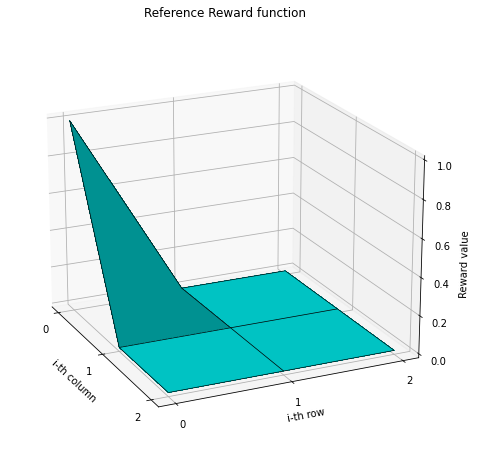

In [64]:
plot_reward_3d(reward_func_ref, show = True, title = "Reference Reward function")

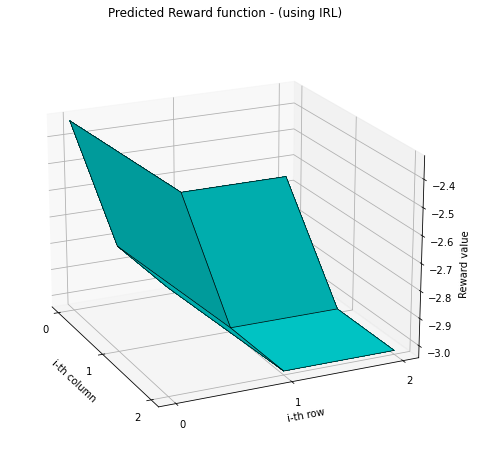

In [65]:
plot_reward_3d(reward_func_estimates[-1], show = True, title = "Predicted Reward function - (using IRL)")

## Table of contents

1. Motivation of IRL
2. Project Goal
3. Inverse Reinforcement Learning (IRL)
4. **Bayesian Inverse Reinforcement Learning (BIRL)**
5. Results
6. Outlook

# 4. Bayesian Inverse Reinforcement Learning (BIRL) (2007)

### Authors
Deepak Ramachandran
Eyal Amir

## Using Bayes' Theorem in IRL

$P(Reward|Observations) = \frac{P(Observations|Reward)\cdot P(Reward)}{P(Observations)}$

## Likelihood

$ \quad P((s_i, a_i)|R) = \frac{1}{Z_i}{e^{\alpha Q^*(s_i, a_i, R)}}$

With which we can now rewrite the likelihood as:

$ \quad P(\{(s_1, a_1), (s_2, a_2), \dots, (s_k, a_k)\}|R) = \frac{1}{Z}{ e^{\alpha \sum_i^k{Q^*(s_i, a_i, R)}}}$

## Posterior

$ \quad P(R|\{(s_1, a_1), (s_2, a_2), \dots, (s_k, a_k)\}) = \frac{1}{Z'}{ e^{\alpha \sum_i^k{Q^*(s_i, a_i, R)}} P(R)}$

## PolicyWalk as sampling algorithm

<img src="presentation/BIRL_Algo.png" width=50%/>

### Hands On - BIRL

In [24]:
def train_value_iteration_new(gw_env: Grid_World, 
                          policy: Dict[Any, Any] = None,
                          value_function: Dict[Any, float] = None,
                          verbose=False,
                          gamma=0.95,
                          training_iterations=1000
                         ) -> Tuple[Dict[Any, Any], Dict[Any, float]]:
    
    vi_agent = ValueIterationAgent(states=gw_env.get_state_space(),
                                   terminal_states=gw_env.get_terminal_states(),
                                   reward_function=gw_env.get_reward_func(),
                                   actions=gw_env.get_action_space(),
                                   gamma=gamma)

    if policy and value_function:
        raise ValueError("Can't pass both policy and value_function arguments at the same time.")
    
    if policy:
        if verbose:
            print("Calculating value function of the given policy via value evaluation...")
        vi_agent.set_value_function(new_value_function=perform_value_evaluation(gw_env, policy, verbose))
        
    if value_function:
        if verbose:
            print("Using the given value function...")
        vi_agent.set_value_function(new_value_function=value_function)
    
    iters = 0
    while iters < training_iterations and not vi_agent.value_converged:

        for state in gw_env.get_state_space():

            if state in gw_env.get_terminal_states():
                continue

            opt_act = vi_agent.get_optimal_action(action_state_pairs=gw_env.get_action_state_pairs(state=state))
            next_state = gw_env.get_new_state_on_action(old_state=state, action=opt_act)
            next_state_value = vi_agent.get_state_value(state=next_state)

            vi_agent.set_state_value(state=state, new_value=(gw_env.get_state_reward(state=next_state) + gamma * next_state_value))

        iters += 1

    if verbose:
        gw_env.display_value_function(value_func=vi_agent.get_value_function())

    vi_agent.construct_greedy_policy(gw_env.get_action_state_pairs)

    if verbose:
        gw_env.display_policy(policy=vi_agent.get_policy())
        
    return vi_agent.get_policy(), vi_agent.get_value_function()


#### Reward Space functionality

In [25]:
def get_random_reward(size: Tuple[int], r_max: float = 1.0, rounding: int = 3) -> np.ndarray:
        
    return np.random.uniform(low=-abs(r_max), high=abs(r_max), size=size).round(rounding)

def get_reward_neighbour(reward: np.ndarray, step_size: float, r_max: float = 1.0) -> np.ndarray:
    
    movement = np.random.randint(low=-1, high=2, size=reward.shape) # random array of -1, 0 and +1
    
    return (reward + step_size * movement).clip(min=-abs(r_max), max=abs(r_max)) # new neighbour reward

In [26]:
get_reward_neighbour(np.array([1, 1, 1, 1, 1, 1]), 0.2)

array([0.8, 1. , 1. , 1. , 1. , 1. ])

#### Prior, Evidence and Posterior Distribution

In [27]:
def improper_prior(reward):
    return 1

def compute_log_posterior(gw_env:Grid_World,
                          observations: List[List[Tuple[Any]]],
                          reward: np.ndarray,
                          policy: Dict[Any, Any],
                          prior: Callable,
                          alpha: float,
                          gamma: float
                         ) -> float:
    
    gw_env.set_board(new_board=reward)
    q = perform_q_function_evaluation(gw_env=gw_env, policy=policy)
    
    log_p = 0
    
    for observation in observations:
        log_p += np.sum([alpha * q[s][a] - np.log(np.sum(np.exp(alpha * np.array(list(q[s].values()))))) for s, a in observation])
        #### Should we use np.mean() here? our obs are not all of the same length
        # log_p += np.mean([alpha * q[s][a] - np.log(np.sum(np.exp(alpha * np.array(list(q[s].values()))))) for s, a in observation])
    
    log_p += np.log(prior(reward))
    
    return log_p

def posterior_dist_ratio(gw_env: Grid_World,
                         observations: List[List[Tuple[Any]]],
                         reward_next: np.ndarray,
                         policy_next: Dict[Any, Any],
                         reward_curr: np.ndarray,
                         policy_curr: Dict[Any, Any]
                        ) -> float:
    
    prior = improper_prior
    alpha = 10
    gamma = GAMMA
    
    log_post_next = compute_log_posterior(gw_env, observations, reward_next, policy_next, prior, alpha, gamma)
    log_post_curr = compute_log_posterior(gw_env, observations, reward_curr, policy_curr, prior, alpha, gamma)
    
    return np.exp(log_post_next - log_post_curr)


In [28]:
def policyWalk(observations: List[List[Tuple[Any]]],
               gw_env: Grid_World,
               step_size: float,
               n_steps: int,
               samples_burn_in: int = 500,
               samples_n_out: int = 5
              ) -> np.ndarray:
    
    # step 1: pick a random reward from the reward space (as np.array)
    reward_0 = get_random_reward(size=gw_env.get_board().shape)
    
    # step 2: get optimal policy given reward_0
    gw_env.set_board(new_board=reward_0)  # board is the np.array representation of the reward function
    policy_0, val_func_0 = train_value_iteration_new(gw_env=gw_env)
    
    posterior_samples = []
    
    # step 3: explore the reward space and sample from the posterior (GridWalk as a MCMC (Metropolis algorithm))
    for i in range(n_steps):
        # step 3a: pick reward_1 from reward_0 neighbours randomly (step_size distance)
        reward_1 = get_reward_neighbour(reward=reward_0, step_size=step_size)
        
        # step 3b: compute the Q function of reward_1 under policy_0
        gw_env.set_board(new_board=reward_1)
        q_func = perform_q_function_evaluation(gw_env=gw_env,
                                               policy=policy_0)
        
        # step 3c: check if ... 
        if is_policy_not_optimal(q_func=q_func, policy=policy_0,
                                 states=gw_env.get_state_space(), actions=gw_env.get_action_space()):
            # step 3c.i: get optimal policy given reward_1 AND policy_0 (we can use the value function of policy_0 directly)
            #### MOTIVATION: since reward_1 is a neighbour of reward_0, policy_1 will be close to policy_0. We use this fact to speed up the computation
            #### would be a repetition of step 3b: gw_env.set_board(new_board=reward_1)
            policy_1, val_func_1 = train_value_iteration_new(gw_env=gw_env,
                                                         value_function=val_func_0)
            
            # step 3c.ii: update reward_0 AND policy_0 with prob. according to the posterior_dist
            if np.random.uniform() < np.minimum(1, posterior_dist_ratio(gw_env, observations, reward_1, policy_1, reward_0, policy_0)):
                reward_0 = deepcopy(reward_1)
                policy_0 = deepcopy(policy_1)
                val_func_0 = deepcopy(val_func_1)
            
        else:
            # step 3c.iii: update reward_0 with prob. according to the posterior_dist
            if np.random.uniform() < np.minimum(1, posterior_dist_ratio(gw_env, observations, reward_1, policy_0, reward_0, policy_0)):
                reward_0 = deepcopy(reward_1)
                
        if (i > samples_burn_in) and (samples_n_out != 0) and ((i - samples_burn_in) % samples_n_out == 0):
            posterior_samples.append(reward_0)

    # step 4: return a sample from the posterior
    if samples_n_out != 0:
        return posterior_samples
    else:
        return reward_0

def is_policy_not_optimal(q_func, policy, states, actions):
    for state in states:
        for action in actions:
            if q_func[state][policy[state]] < q_func[state][action]:
                return True
    return False


In [76]:
GAMMA = 0.95

VALUE_ITERATION_TRAINING_N = 1000

GW_SIZE = (3, 3)
GW_TRAPS = []
GW_GOALS = [(0, 0)]

NUMBER_OF_STATES = GW_SIZE[0] * GW_SIZE[1]

NUMBER_OF_TRAJECTORIES    = NUMBER_OF_STATES * 20
MAXIMUM_TRAJECTORY_LENGTH = NUMBER_OF_STATES * 4

BIRL_N_OF_POSTERIOR_SAMPLES     = 2
BIRL_POLICYWALK_STEP_SIZE       = 0.05
BIRL_POLICYWALK_N_STEPS         = int(NUMBER_OF_STATES / BIRL_POLICYWALK_STEP_SIZE * 20)
BIRL_POLICYWALK_SAMPLES_BURN_IN = int(BIRL_POLICYWALK_N_STEPS * 0.7)
BIRL_POLICYWALK_SAMPLES_N_OUT   = 10


In [77]:
environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)

target_reward = environment.get_board()

vi_greedy_policy, vi_greedy_value_function = train_value_iteration_new(gw_env=environment, verbose=True, gamma=GAMMA, training_iterations=VALUE_ITERATION_TRAINING_N)

print(f"Generating {NUMBER_OF_TRAJECTORIES} trajectories...")

trajectories = environment.generate_trajectories(policy=vi_greedy_policy,
                                                 n_traj=NUMBER_OF_TRAJECTORIES,
                                                 max_traj_length=MAXIMUM_TRAJECTORY_LENGTH,
                                                 return_state_action_pairs=True)


Value function:
[[0.       1.       0.95    ]
 [1.       0.95     0.9025  ]
 [0.95     0.9025   0.857375]]
Policy:
[['x' '<' '<']
 ['^' '<' '<']
 ['^' '<' '<']]
Generating 180 trajectories...


### Manually go through one iteration of policy walk

In [78]:
environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)
policy_opt, val_func_opt = train_value_iteration_new(gw_env=environment)

# step 1: pick a random reward from the reward space (as np.array)
reward_0 = get_random_reward(size=environment.get_board().shape)

reward_func_ref = deepcopy(environment.get_board())

print("target reward: ")
print(environment.get_board())
print()

print("optimal policy:")
print(get_display_policy(policy = policy_opt, actions_to_str_map=actions_to_str_map, size=GW_SIZE, terminal_states=GW_GOALS))
print()

target reward: 
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

optimal policy:
[['x' '<' '<']
 ['^' '<' '<']
 ['^' '<' '<']]



In [79]:
# step 2: get optimal policy given reward_0
environment.set_board(new_board=reward_0)  # board is the np.array representation of the reward function
policy_0, val_func_0 = train_value_iteration_new(gw_env=environment)

print("randomly initialised reward: ")
print(reward_0)
print()

print("new policy generated by new reward function: ")
print(get_display_policy(policy = policy_0, actions_to_str_map=actions_to_str_map, size=GW_SIZE, terminal_states=GW_GOALS))

randomly initialised reward: 
[[ 0.595  0.913 -0.69 ]
 [ 0.674 -0.432  0.193]
 [-0.373 -0.071  0.518]]

new policy generated by new reward function: 
[['x' 'v' 'v']
 ['>' '>' 'v']
 ['>' '>' '^']]


In [80]:
observations=trajectories
gw_env=environment
step_size=BIRL_POLICYWALK_STEP_SIZE
n_steps=BIRL_POLICYWALK_N_STEPS
samples_burn_in=BIRL_POLICYWALK_SAMPLES_BURN_IN
samples_n_out=BIRL_POLICYWALK_SAMPLES_N_OUT

In [81]:
posterior_samples = []

# step 3: explore the reward space and sample from the posterior (GridWalk as a MCMC (Metropolis algorithm))
for i in tqdm(range(BIRL_POLICYWALK_N_STEPS)):
    # step 3a: pick reward_1 from reward_0 neighbours randomly (step_size distance)
    reward_1 = get_reward_neighbour(reward=reward_0, step_size=BIRL_POLICYWALK_STEP_SIZE)

    # step 3b: compute the Q function of reward_1 under policy_0
    environment.set_board(new_board=reward_1)
    q_func = perform_q_function_evaluation(gw_env=environment,
                                           policy=policy_0)

    # step 3c: check if ... 
    if is_policy_not_optimal(q_func=q_func, policy=policy_0,
                             states=environment.get_state_space(), actions=environment.get_action_space()):
        # step 3c.i: get optimal policy given reward_1 AND policy_0 (we can use the value function of policy_0 directly)
        #### MOTIVATION: since reward_1 is a neighbour of reward_0, policy_1 will be close to policy_0. We use this fact to speed up the computation
        #### would be a repetition of step 3b: gw_env.set_board(new_board=reward_1)
        policy_1, val_func_1 = train_value_iteration_new(gw_env=environment,
                                                     value_function=val_func_0)

        # step 3c.ii: update reward_0 AND policy_0 with prob. according to the posterior_dist
        if np.random.uniform() < np.minimum(1, posterior_dist_ratio(environment, trajectories, reward_1, policy_1, reward_0, policy_0)):
            reward_0 = deepcopy(reward_1)
            policy_0 = deepcopy(policy_1)
            val_func_0 = deepcopy(val_func_1)

    else:
        # step 3c.iii: update reward_0 with prob. according to the posterior_dist
        if np.random.uniform() < np.minimum(1, posterior_dist_ratio(environment, trajectories, reward_1, policy_0, reward_0, policy_0)):
            reward_0 = deepcopy(reward_1)

    if (i > BIRL_POLICYWALK_SAMPLES_BURN_IN) and (BIRL_POLICYWALK_SAMPLES_N_OUT != 0) and ((i - BIRL_POLICYWALK_SAMPLES_BURN_IN) % BIRL_POLICYWALK_SAMPLES_N_OUT == 0):
        posterior_samples.append(reward_0)


  0%|                                                                                         | 0/3600 [00:00<?, ?it/s]<ipython-input-27-1f386c5265ec>:42: RuntimeWarning: overflow encountered in exp
  return np.exp(log_post_next - log_post_curr)
100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:46<00:00, 77.18it/s]


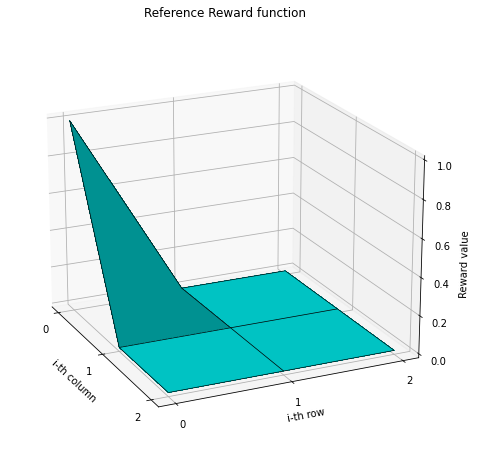

In [82]:
plot_reward_3d(reward_func_ref, show = True, title = "Reference Reward function")

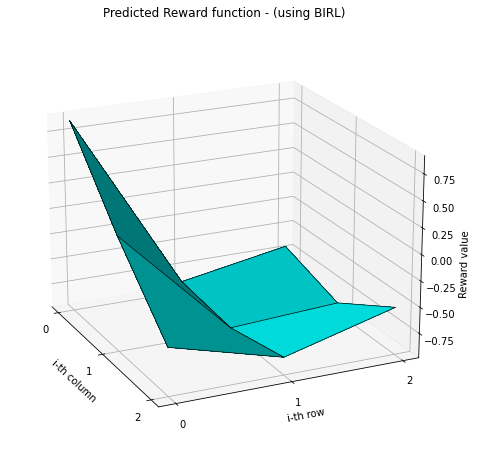

In [83]:
plot_reward_3d(np.mean(posterior_samples, axis=0), show = True, title = "Predicted Reward function - (using BIRL)")

#### Run multiple iterations for posterior sampling

In [37]:
GAMMA = 0.95

VALUE_ITERATION_TRAINING_N = 1000

GW_SIZE = (3, 3)
GW_TRAPS = []
GW_GOALS = [(0, 2)]

NUMBER_OF_STATES = GW_SIZE[0] * GW_SIZE[1]

NUMBER_OF_TRAJECTORIES    = NUMBER_OF_STATES * 20
MAXIMUM_TRAJECTORY_LENGTH = NUMBER_OF_STATES * 4

BIRL_N_OF_POSTERIOR_SAMPLES     = 10
BIRL_POLICYWALK_STEP_SIZE       = 0.05
BIRL_POLICYWALK_N_STEPS         = int(NUMBER_OF_STATES / BIRL_POLICYWALK_STEP_SIZE * 20)
BIRL_POLICYWALK_SAMPLES_BURN_IN = int(BIRL_POLICYWALK_N_STEPS * 0.7)
BIRL_POLICYWALK_SAMPLES_N_OUT   = 10


In [38]:
print(f"Generate {BIRL_N_OF_POSTERIOR_SAMPLES} samples from the posterior")

posterior_samples = []

for _ in tqdm(range(BIRL_N_OF_POSTERIOR_SAMPLES)):
    
    # restart the environment
    environment = Grid_World(size=GW_SIZE, traps=GW_TRAPS, goals=GW_GOALS, randomize_board=False)

    posterior_samples += policyWalk(observations=trajectories,
                                    gw_env=environment,
                                    step_size=BIRL_POLICYWALK_STEP_SIZE,
                                    n_steps=BIRL_POLICYWALK_N_STEPS,
                                    samples_burn_in=BIRL_POLICYWALK_SAMPLES_BURN_IN,
                                    samples_n_out=BIRL_POLICYWALK_SAMPLES_N_OUT)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Generate 10 samples from the posterior


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [35:08<00:00, 210.87s/it]


### Now with multiple iterations for posterior sampling

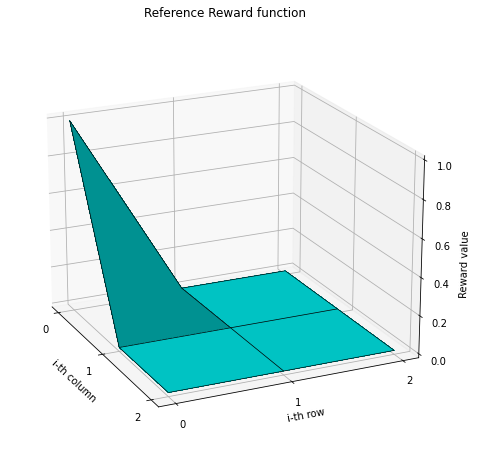

In [66]:
plot_reward_3d(reward_func_ref, show = True, title = "Reference Reward function")

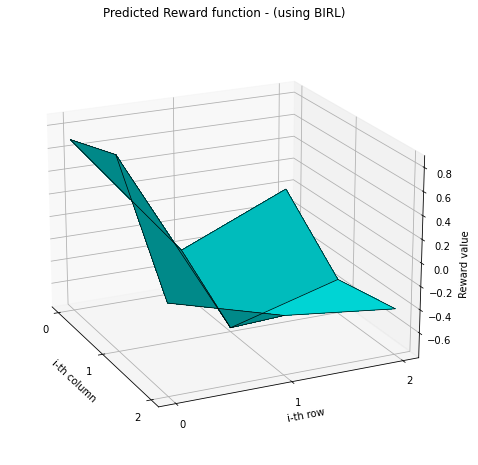

In [67]:
plot_reward_3d(np.mean(posterior_samples, axis=0), show = True, title = "Predicted Reward function - (using BIRL)")

## Table of contents

1. Motivation of IRL
2. Project Goal
3. Inverse Reinforcement Learning (IRL)
4. Bayesian Inverse Reinforcement Learning (BIRL)
5. **Results**
6. Outlook

# 5. Results

## Loss plots

<img src="presentation/loss_plots.png"/>

## Table of contents

1. Motivation of IRL
2. Project Goal
3. Inverse Reinforcement Learning (IRL)
4. Bayesian Inverse Reinforcement Learning (BIRL)
5. Results
6. **Outlook**

# 6. Outlook

- reproduce other plots for k-greedy
- evaluate efficiency of each algorithm and possibly find ways to optimize

# Questions?

- References
    - Ng, Andrew Y., and Stuart Russell. "Algorithms for inverse reinforcement learning." Icml. Vol. 1. 2000.
    - Ramachandran, Deepak, and Eyal Amir. "Bayesian Inverse Reinforcement Learning." IJCAI. Vol. 7. 2007.
- Code base
    - https://github.com/NiklasAndMaxRL/IRL_project